In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/model-run-soutrik/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey"
)
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/model-run-soutrik/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey'

##### Basic Imports

In [3]:
import os
import timm

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

import lightning as L
from lightning.pytorch import Trainer

from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from pathlib import Path
from typing import Union

import matplotlib.pyplot as plt

# from IPython.display import Image
from pydantic.v1 import BaseModel, Field, BaseSettings
from dotenv import load_dotenv, find_dotenv
import kaggle
import zipfile
import yaml, shutil
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

In [4]:
from loguru import logger

In [5]:
load_dotenv(find_dotenv(".env"))

True

In [6]:
class DataConfig(BaseModel):
    data_dir: str = Field(..., description="Path to the data directory")
    kaggle_dataset_path: str = Field(..., description="Path to the kaggle dataset")

In [7]:
class Settings(BaseSettings):
    kaggle_username: str = os.environ.get("KAGGLE_USERNAME")
    kaggle_key: str = os.environ.get("KAGGLE_KEY")
    data_config: DataConfig

In [8]:
def load_yaml_config() -> dict:
    # Load static values from config.yaml
    config_path = f"./config.yaml"
    try:
        with open(config_path, "r", encoding="utf-8") as file:
            return yaml.safe_load(file)
    except Exception as e:
        logger.error(f"Error loading config from service path, trying config.yaml: {e}")
        try:
            with open("config.yaml", "r", encoding="utf-8") as file:
                return yaml.safe_load(file)
        except Exception as e:
            logger.error(f"Error loading fallback config.yaml: {e}")
            raise

In [9]:
yaml_config = load_yaml_config()
settings = Settings(**yaml_config)

In [10]:
def download_data_kaggle(settings: Settings):

    # Download the dataset
    kaggle.api.dataset_download_files(
        settings.data_config.kaggle_dataset_path, path="./", unzip=False
    )
    if os.path.exists(settings.data_config.data_dir):
        logger.info("Data directory already exists")
        shutil.rmtree("./" + settings.data_config.data_dir)
    # Unzip the dataset
    with zipfile.ZipFile(
        f'{settings.data_config.kaggle_dataset_path.split("/")[-1]}.zip', "r"
    ) as zip_ref:
        zip_ref.extractall(
            os.path.join(
                settings.data_config.data_dir,
                settings.data_config.kaggle_dataset_path.split("/")[-1],
            )
        )

In [11]:
download_data_kaggle(settings)

2024-09-29 18:14:14.025 | INFO     | __main__:download_data_kaggle:8 - Data directory already exists


In [12]:
TRAIN_PATH = Path(
    f"{settings.data_config.data_dir}/{settings.data_config.kaggle_dataset_path.split('/')[-1]}/dataset"
)
IMAGE_PATH_LIST = list(TRAIN_PATH.glob("*/*.jpg"))
print(f"Total Images = {len(IMAGE_PATH_LIST)}")

Total Images = 967


In [13]:
# creating a mapping file for the classes
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i, img_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = img_path
    labels[i] = img_path.parent.stem

dataset_df = pd.DataFrame({"image_path": images_path, "label": labels})

dataset_df.head()

,image_path,label
0,data/dog-breed-image-dataset/dataset/Beagle/Be...,Beagle
1,data/dog-breed-image-dataset/dataset/Beagle/Be...,Beagle
2,data/dog-breed-image-dataset/dataset/Beagle/Be...,Beagle
3,data/dog-breed-image-dataset/dataset/Beagle/Be...,Beagle
4,data/dog-breed-image-dataset/dataset/Beagle/Be...,Beagle


In [14]:
def _load(image_path, as_tensor=True):

    image = Image.open(image_path)

    if as_tensor:
        converter = transforms.ToTensor()
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map="rgb", fig_size=(8, 10)):
    plt.figure(figsize=fig_size)

    if color_map == "rgb":
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)

    plt.title(f"Label: {label}", fontsize=16)
    return

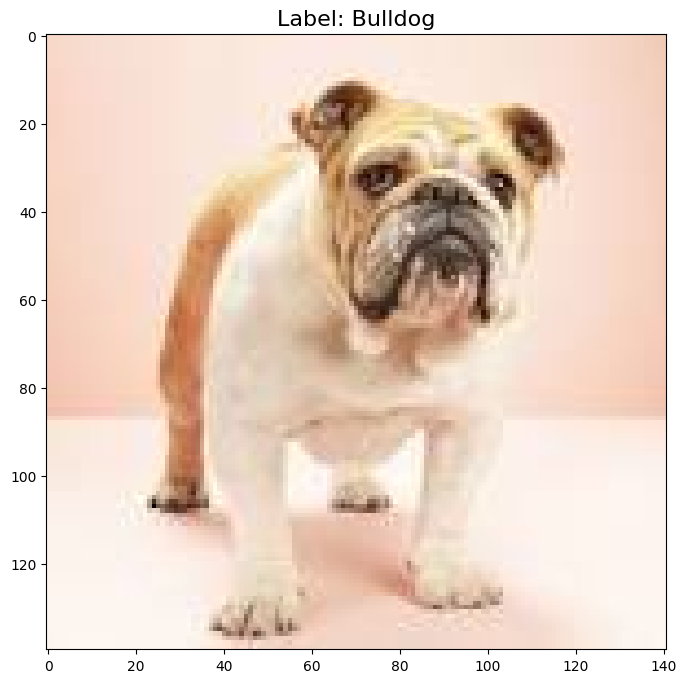

In [15]:
# Select random sample from train_df
idx = random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(dataset_df.image_path[idx]), dataset_df.label[idx]

# View the random sample
view_sample(sample_image.permute(1, 2, 0), sample_label)

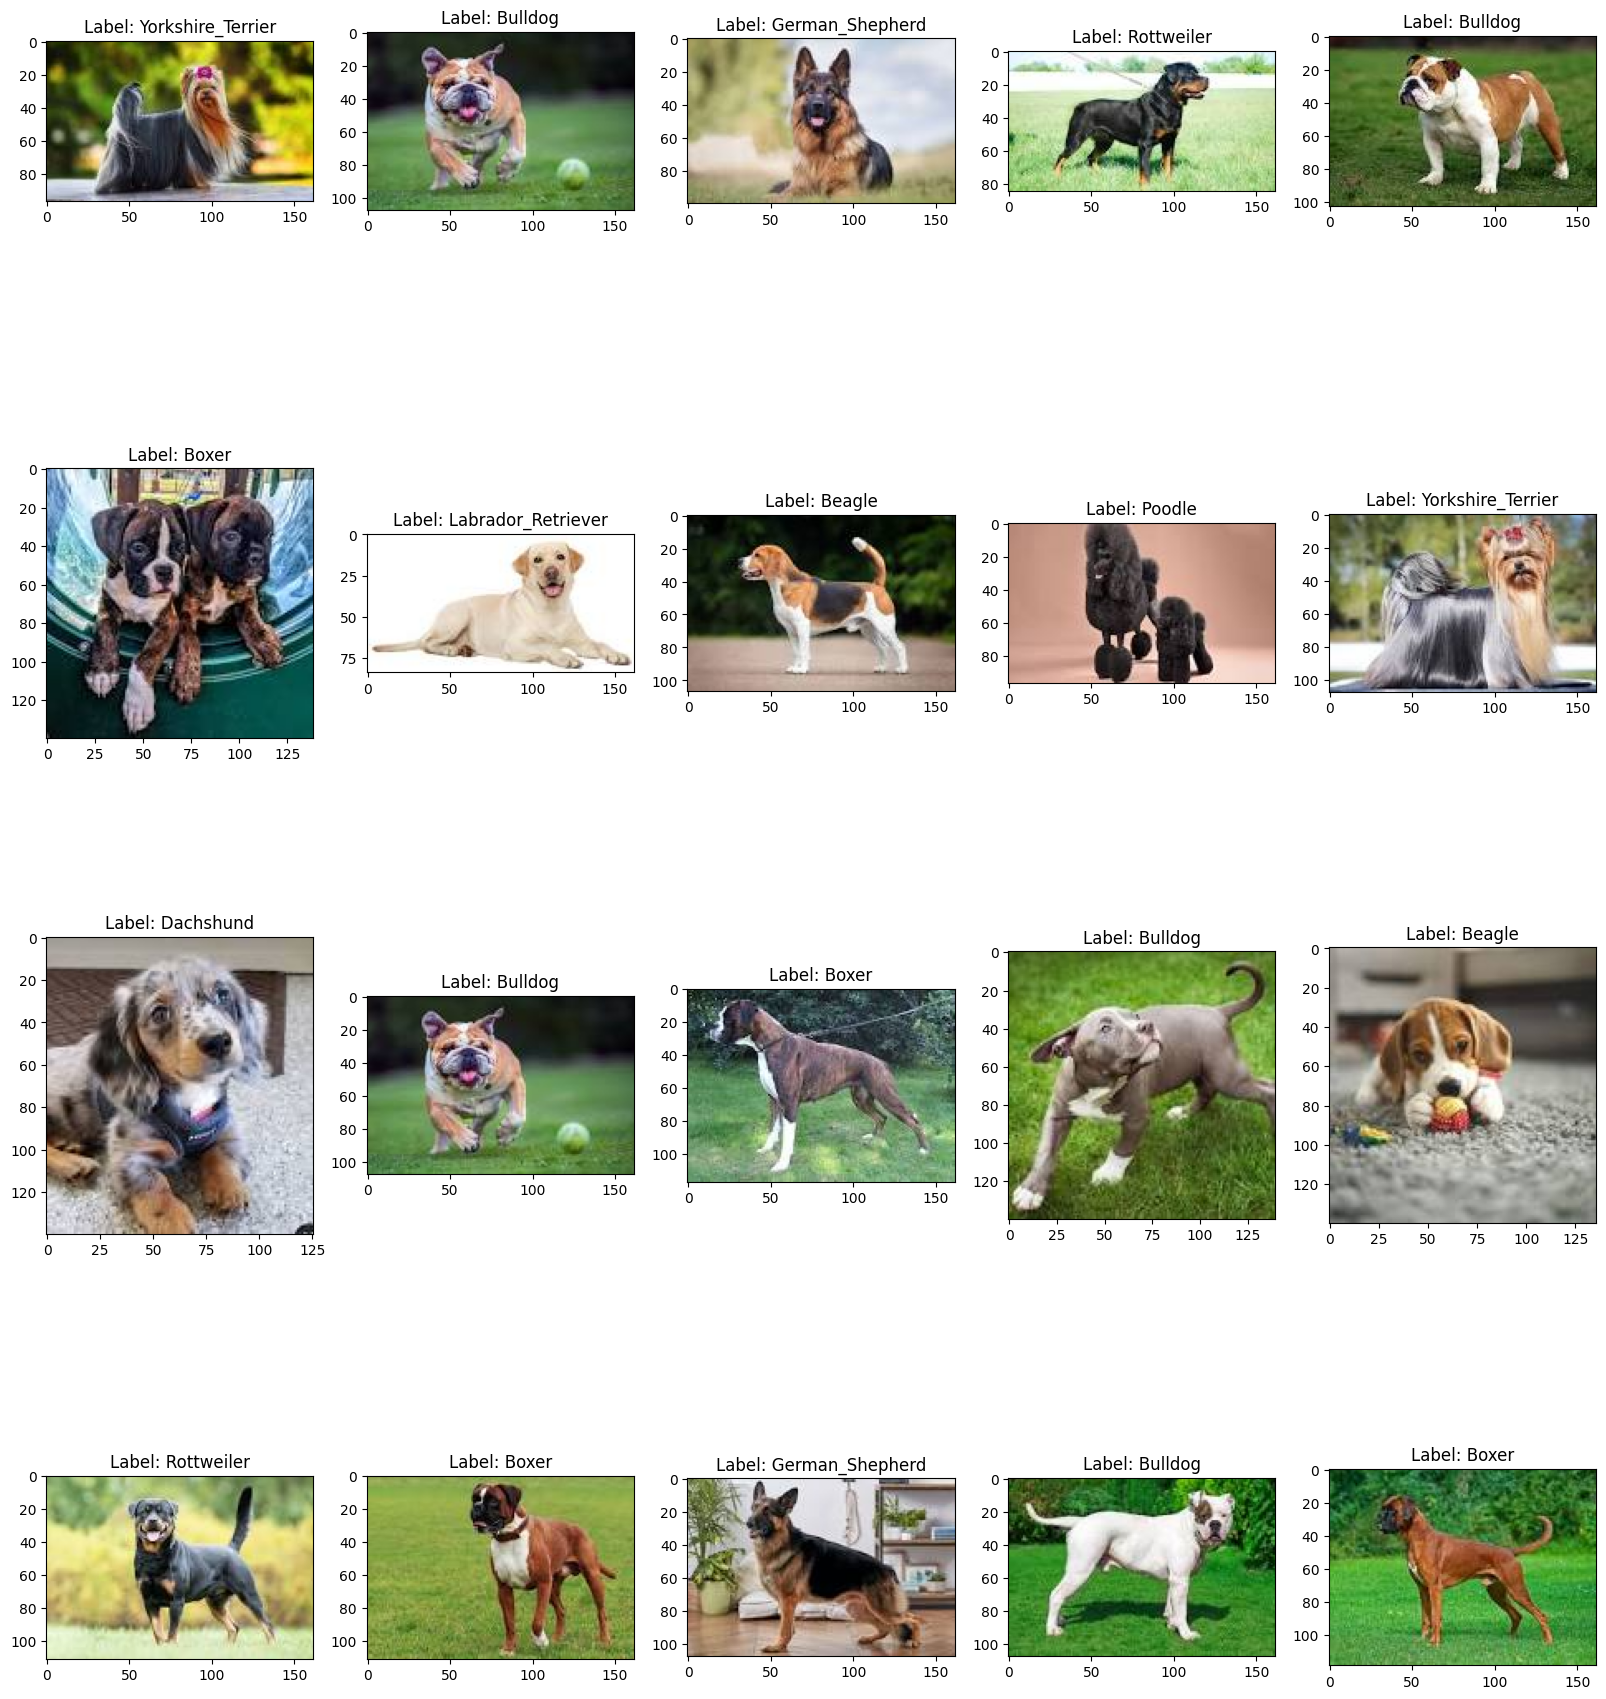

In [16]:
def view_mulitiple_samples(
    df, sample_loader, count=10, color_map="rgb", fig_size=(14, 10)
):
    rows = count // 5
    if count % 5 > 0:
        rows += 1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column + 1)
        plt.title(f"Label: {df.label[_]}")

        if color_map == "rgb":
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0))
        else:
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0), cmap=color_map)

    return


view_mulitiple_samples(
    dataset_df, _load, count=20, fig_size=(20, 24)  # View 20 random sample images
)

##### Dataloading using PytorchDataset and then Pytorch Lightning DataModule for trainable dataloader

In [17]:
L.seed_everything(42, workers=True)

Seed set to 42


42

In [18]:
class DogbreedDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None) -> None:
        """
        Args:
            df (pd.DataFrame): DataFrame containing image paths and labels.
            transform: A function/transform that takes in a PIL image and returns a transformed version.
        """
        super().__init__()

        self.paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()
        self.transform = transform

        self.classes = sorted(df["label"].unique())
        self.class_to_idx = {
            cls_name: idx for idx, cls_name in enumerate(self.classes)
        }  # Map class names to indices

    def load_image(self, index: int) -> Image.Image:
        """Load image from file."""
        image_path = self.paths[index]
        return Image.open(image_path).convert("RGB")

    def __len__(self) -> int:
        """Return total number of samples."""
        return len(self.paths)

    def __getitem__(self, index: int):
        """Retrieve an image and its corresponding label."""
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, class_idx

In [19]:
# def normalize_transform():
#     return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


# def train_transform():
#     return transforms.Compose(
#         [
#             transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize_transform(),
#         ]
#     )

In [20]:
# # Create dataset
# dataset = DogbreedDataset(dataset_df, transform=train_transform())

# # Example usage
# image, label = dataset[0]  # Get the first image and its label
# print(f"Image shape: {image.shape}, Label: {label}")

In [21]:
class CatDogImageDataModule(L.LightningDataModule):
    def __init__(self, dataset_df, num_workers: int = 0, batch_size: int = 8):
        """
        Initialize the DataModule with dataset DataFrame, batch size, and number of workers.

        Args:
            dataset_df (pd.DataFrame): DataFrame containing image paths and labels.
            num_workers (int): Number of workers for data loading.
            batch_size (int): Batch size for DataLoader.
        """
        super().__init__()
        self.dataset_df = dataset_df  # Store the DataFrame with image paths and labels
        self.num_workers = num_workers  # Set number of workers for data loading
        self.batch_size = batch_size  # Set the batch size

    @property
    def normalize_transform(self):
        """Return normalization transform for the images."""
        return transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    @property
    def train_transform(self):
        """Return a composition of data augmentations and transformations for training."""
        return transforms.Compose(
            [
                transforms.Resize((224, 224)),  # Resize image to 224x224
                transforms.RandomHorizontalFlip(),  # Random horizontal flip
                transforms.ToTensor(),  # Convert to tensor
                self.normalize_transform,  # Normalize the image
            ]
        )

    def setup(self, stage: str = None):
        """
        Called by Lightning to initialize the datasets for the train, val, and test stages.
        This method sets up the datasets depending on the current stage.

        Args:
            stage (str): Either 'fit', 'test', or None.
        """
        dataset = DogbreedDataset(self.dataset_df, transform=self.train_transform)

        if stage == "fit" or stage is None:
            # Split dataset into train (80%) and val (10%)
            train_size = int(0.8 * len(dataset))
            val_size = len(dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(
                dataset, [train_size, val_size]
            )

        if stage == "test":
            # use the val_dataset for testing
            train_size = int(0.8 * len(dataset))
            val_size = len(dataset) - train_size
            self.train_dataset, self.test_dataset = random_split(
                dataset, [train_size, val_size]
            )

    def train_dataloader(self):
        """Return the DataLoader for the training set."""
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,  # Shuffle data during training
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        """Return the DataLoader for the validation set."""
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,  # Do not shuffle validation data
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        """Return the DataLoader for the test set."""
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,  # Do not shuffle test data
            num_workers=self.num_workers,
        )

In [22]:
# Assuming dataset_df is a DataFrame with "image_path" and "label" columns
data_module = CatDogImageDataModule(dataset_df=dataset_df, batch_size=32, num_workers=4)
data_module.setup()

In [23]:
#  Visualization: Dataset sample
def show_batch(data_module, num_images=4):
    batch = next(iter(data_module.train_dataloader()))
    images, labels = batch
    grid = make_grid(images[:num_images])
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Sample batch from the dataset")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


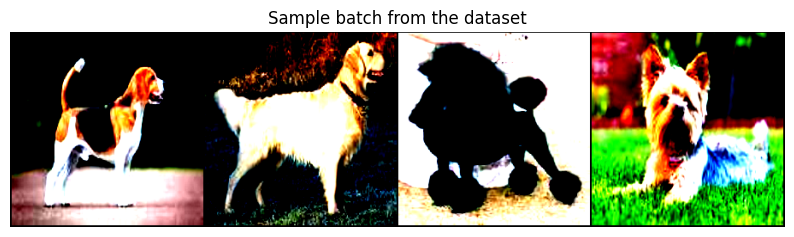

In [24]:
show_batch(data_module)

##### MODEL SETUP

In [25]:
labels = dataset_df.label.nunique()
print(f"Total classes: {labels}")

Total classes: 10


In [26]:
class DogBreedClassifier(L.LightningModule):
    def __init__(self, num_classes: int, lr: float = 1e-3):
        """
        Initialize the DogBreedClassifier.

        Args:
            num_classes (int): The number of dog breed classes.
            lr (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.weight_decay = 1e-6
        self.scheduler_factor = 0.1
        self.scheduler_patience = 2
        self.min_lr = 1e-6

        # Load pre-trained ResNet18 model and adjust the final layer for the correct number of classes
        self.model = timm.create_model(
            "resnet18", pretrained=True, num_classes=num_classes
        )

        # Initialize accuracy metrics for multi-class classification
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)

        # Save hyperparameters for logging and checkpointing
        self.save_hyperparameters()

    def forward(self, x):
        """Forward pass through the model."""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Training step logic."""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Use logits to compute accuracy
        self.train_acc(logits, y)

        # Log loss and accuracy
        self.log("train_loss", loss, prog_bar=True)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_step=False, on_epoch=True
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step logic."""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Use logits to compute accuracy
        self.val_acc(logits, y)

        # Log validation loss and accuracy
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True, on_step=False, on_epoch=True)

    # add test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Use logits to compute accuracy
        self.val_acc(logits, y)

        # Log validation loss and accuracy
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.val_acc, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):

        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.weight_decay,
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            factor=self.scheduler_factor,
            patience=self.scheduler_patience,
            min_lr=self.min_lr,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
            "interval": "epoch",
        }

In [27]:
# Visualization: Model Architecture
def visualize_model(model):
    from torchviz import make_dot
    from IPython.display import Image, display

    x = torch.randn(1, 3, 224, 224)
    y = model(x)
    dot = make_dot(y, params=dict(model.named_parameters()))
    dot.render("model_architecture", format="png")
    display(Image("model_architecture.png"))

In [28]:
model = DogBreedClassifier(num_classes=labels)

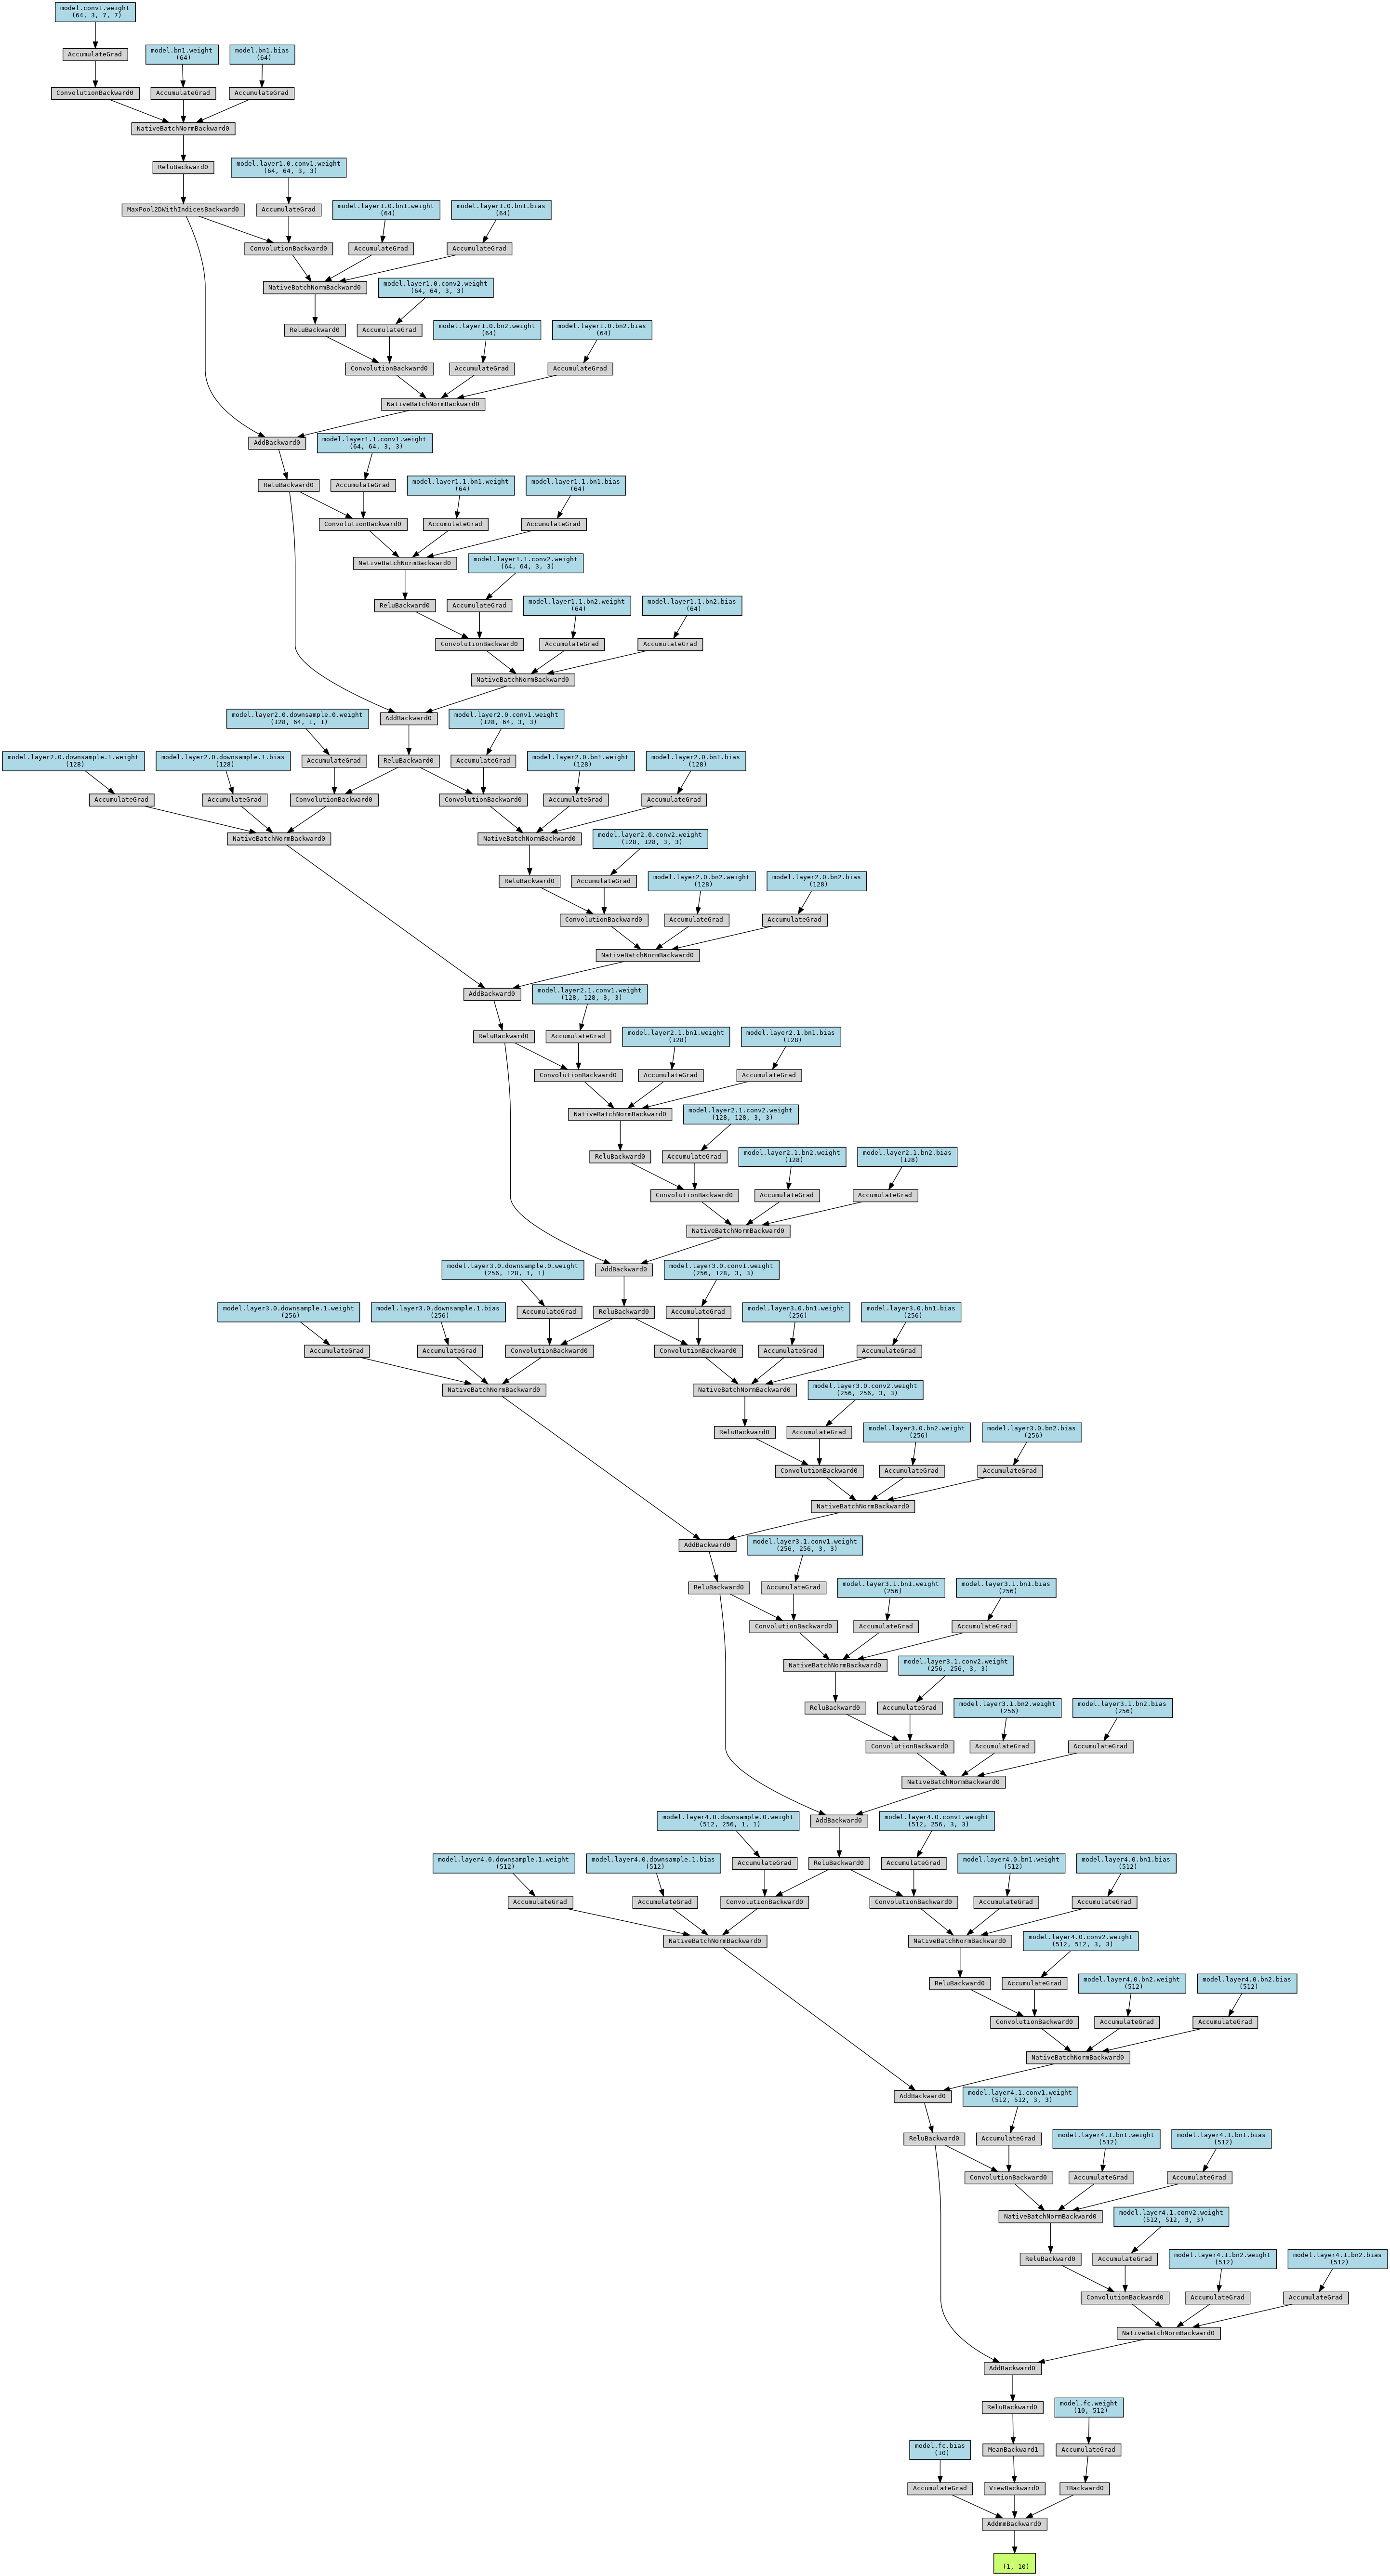

In [29]:
visualize_model(model)

##### MODEL TRAINING

In [30]:
# datamodule defined
data_module = CatDogImageDataModule(dataset_df=dataset_df, batch_size=32, num_workers=4)
data_module.setup(stage="train")

In [31]:
# Initialize ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="best-checkpoint",
    save_top_k=1,
    mode="min",
)

# Initialize Trainer
trainer = Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    accelerator="auto",
    logger=TensorBoardLogger(save_dir="logs", name="ex-01"),
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [32]:
# Train the model
trainer.fit(model, data_module)

2024-09-29 18:15:38.645695: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 18:15:38.645740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 18:15:38.646660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 18:15:38.652778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 18:15:39.442255: W tensorflow/compiler/tf2

Sanity Checking: |                                                                                            …

/anaconda/envs/torch_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


In [33]:
# test the model
data_module.setup(stage="test")
trainer.test(
    model,
    datamodule=data_module,
    verbose=True,
    ckpt_path=trainer.checkpoint_callback.best_model_path,
)

Restoring states from the checkpoint path at /mnt/batch/tasks/shared/LS_root/mounts/clusters/model-run-soutrik/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/checkpoints/best-checkpoint-v7.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/batch/tasks/shared/LS_root/mounts/clusters/model-run-soutrik/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/checkpoints/best-checkpoint-v7.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.013318208046257496    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.013318208046257496, 'test_acc': 1.0}]

In [34]:
%load_ext tensorboard

In [35]:
%tensorboard --logdir logs

Launching TensorBoard...

##### Inference #####

In [36]:
best_model_path = checkpoint_callback.best_model_path
model = DogBreedClassifier.load_from_checkpoint(best_model_path)

In [37]:
best_model_path

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/model-run-soutrik/code/Users/Soutrik.Chowdhury/pytorch_lightning_journey/checkpoints/best-checkpoint-v7.ckpt'

In [38]:
classes = dataset_df.label.unique().tolist()
print(f"Classes: {classes}")

Classes: ['Beagle', 'Boxer', 'Bulldog', 'Dachshund', 'German_Shepherd', 'Golden_Retriever', 'Labrador_Retriever', 'Poodle', 'Rottweiler', 'Yorkshire_Terrier']


In [39]:
def inference(model, image_path, classes):
    from PIL import Image as PILImage

    # Load and preprocess the image
    img = PILImage.open(image_path).convert("RGB")

    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Apply the transform to the image
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Move the input tensor to the same device as the model
    img_tensor = img_tensor.to(model.device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Map the predicted class to the label
    class_labels = classes
    predicted_label = class_labels[predicted_class]
    confidence = probabilities[0][predicted_class].item()

    # Display the image and prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Predicted: {predicted_label.capitalize()} (Confidence: {confidence:.2f})"
    )
    plt.show()

    return predicted_label, confidence

In [40]:
!wget --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3" -O dog.jpg "https://images.pexels.com/photos/2253275/pexels-photo-2253275.jpeg?auto=compress&cs=tinysrgb&w=600"

--2024-09-29 18:16:39--  https://images.pexels.com/photos/2253275/pexels-photo-2253275.jpeg?auto=compress&cs=tinysrgb&w=600
Resolving images.pexels.com (images.pexels.com)... 104.18.66.220, 104.18.67.220, 2606:4700::6812:42dc, ...
Connecting to images.pexels.com (images.pexels.com)|104.18.66.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25396 (25K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  24.80K  --.-KB/s    in 0s      

2024-09-29 18:16:39 (122 MB/s) - ‘dog.jpg’ saved [25396/25396]



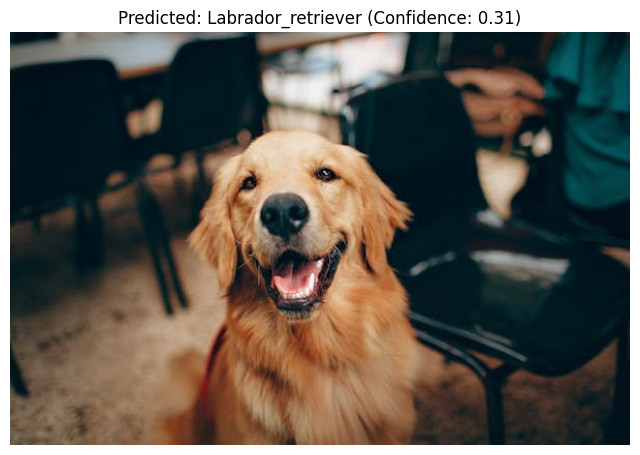

('Labrador_Retriever', 0.3063715398311615)

In [41]:
inference(model, "dog.jpg", classes)

In [1]:
import requests

In [11]:
import requests

url = "https://images.pexels.com/photos/2253275/pexels-photo-2253275.jpeg?auto=compress&cs=tinysrgb&w=600"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

response = requests.get(url, headers=headers, allow_redirects=True)

if response.status_code == 200:
    with open("./dog.jpg", "wb") as file:
        file.write(response.content)
    print("Image downloaded successfully as dog.jpg!")
else:
    print(f"Failed to download image. Status code: {response.status_code}")

Image downloaded successfully as dog.jpg!


In [12]:
response.status_code

200

In [16]:
a = "dog.jpg"

In [23]:
# chekc if the suffix is jpg or jpeg
if a.endswith(".jpg") or a.endswith(".jpeg"):
    print("Yes")

Yes
